<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Константная-модель" data-toc-modified-id="Константная-модель-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Константная модель</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Линейная регрессия</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import (
    LinearRegression,
    Lasso
) 

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    TimeSeriesSplit,
    train_test_split   
)
 
from statsmodels.tsa.seasonal import seasonal_decompose

Загрузка данных

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
display(data.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.shape

(26496, 1)

Проведем семплирование данны, 1 час

In [6]:
data_res = data.resample('1H').sum()

In [7]:
data_res.shape

(4416, 1)

Визуализируем данные на графике

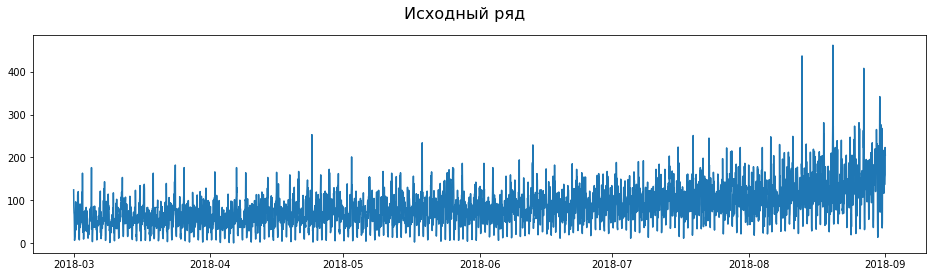

In [8]:
fig = plt.figure(figsize=(16, 4))
plt.suptitle('Исходный ряд', fontsize=16)
plt.plot(data_res)
plt.show()

Из графика видно, что есть есть небольшой тренд на увеличение после 6 месяца, особенно заметно в 8. При дальнешем анализе нужно обратить на это внимание.

## Анализ

Чтобы лучше понимать временной ряд, разделим его на тренды и сезонность

Напишем функцию построения графиков: тред, сезонность, остаток

In [9]:
def show_trens_seas_res(data):
    
    decomposed = seasonal_decompose(data)
    
    plt.figure(figsize=(12, 12))
    plt.suptitle("График тренд/скозоность/остаток", fontsize=16)
    plt.grid()
    
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca()) 
    plt.grid()
    plt.xlabel("Время")
    plt.ylabel("Кол-во заказов")
    plt.title('Тренд')
    
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.xlabel("Время")
    plt.ylabel("Кол-во заказов")
    plt.title('Сезонность')
    
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.grid()
    plt.xlabel("Время")
    plt.ylabel("Кол-во заказов")
    plt.title('Остаток')
    
    plt.tight_layout()

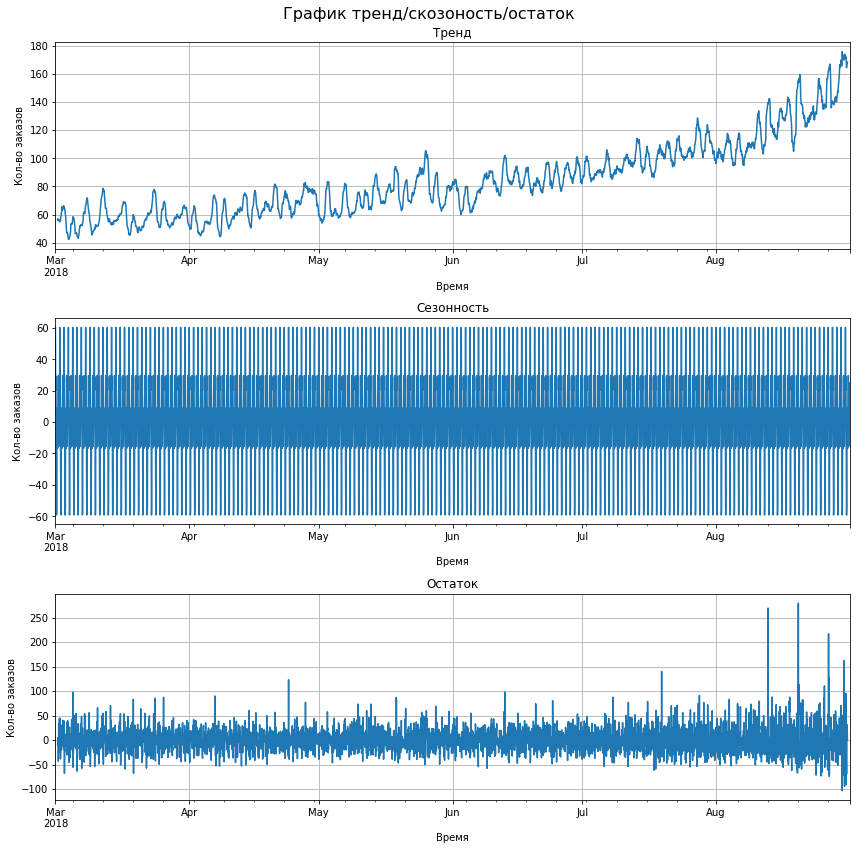

In [10]:
show_trens_seas_res(data_res)

Чтобы более детально рассмотреть данные построим графики для 1 месяца. Выберем последний месяц - август, 08:

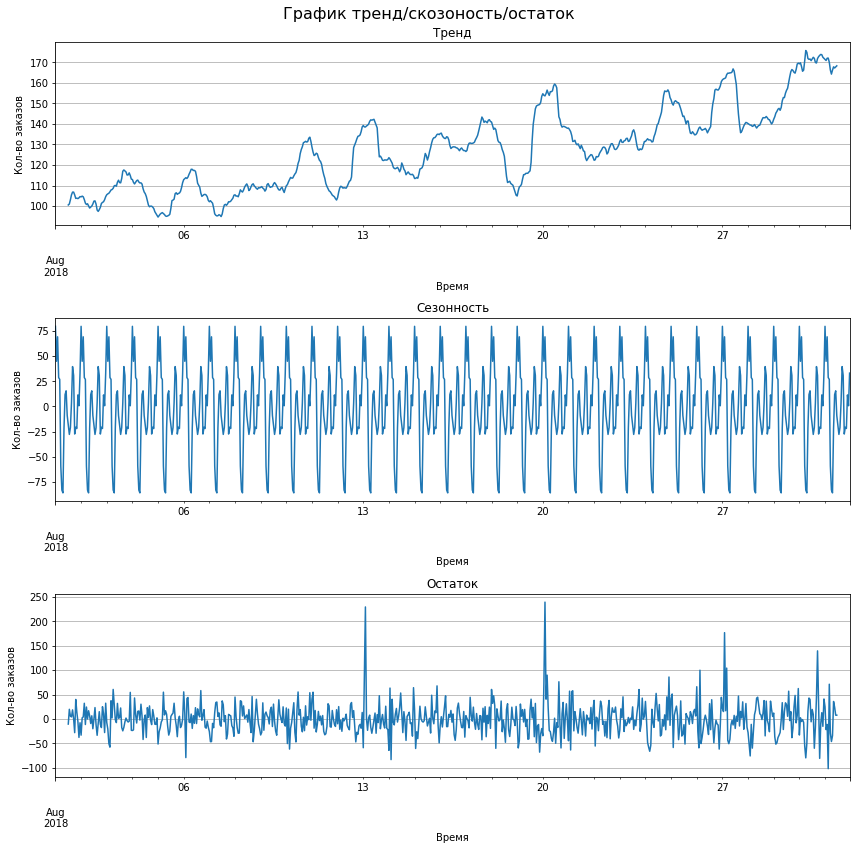

In [11]:
show_trens_seas_res(data_res['2018-08':])

- На графике треда мы видим рост,
- Сезонная частьявляется статической, если рассмтривать  интервал 1 сутки,
- Наблюдается постоянное среднее значение у случайной части,
- Так же есть всплески в днях являющимся выходными.

## Обучение

In [12]:
data_res.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Константная модель

Построим константную модель. В качестве предсказания будем использовать предыдущие значения, то есть будем предсказывать новые значения предыдущими.

In [13]:
# резделим выборку на обучающу и тестовую
train, test = train_test_split(data_res, shuffle=False, test_size=0.1)
# удалим пропуски
train = train.dropna()
# сделаем сдвиг
prediction_previous = test.shift()
# возьмем нулевое занчение из обучающей выборки
prediction_previous.iloc[0] = train.iloc[-1]
# расчитаем RMSE
rmse_base =  mean_squared_error(test['num_orders'], prediction_previous) ** 0.5
print("RMSE линейной модели:", round(rmse_base, 2))

RMSE линейной модели: 58.86


### Подготовка данных

Напишем функцию для создания признаков, в которую войдут:
- Календарные признаки - dayofweek, day, hour
- «Отстающие значения» - max_lag
- Скользящее среднее - rolling_mean_size

In [14]:
def make_features(data_a, max_lag, rolling_mean_size):
    data = data_a.copy()
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data


In [15]:
# check
display(make_features(data_res, 1, 1).head(3))

,num_orders,hour,day,dayofweek,lag_1,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,124.0
2018-03-01 02:00:00,71,2,1,3,85.0,85.0


Создадим данные с признаками:

In [16]:
data_for_analize = make_features(data_res, 20, 30)

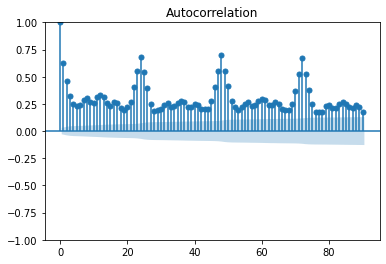

In [17]:

from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(data_for_analize['num_orders'],lags= 90)
plt.show() 



Разделим выборку на тестовую и обучающую

In [18]:
train, test = train_test_split(data_for_analize, shuffle=False, test_size=0.1)

Удалим строки с пустыми значениями

In [19]:
train = train.dropna()

In [20]:
#check
display(train.head(3))

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 06:00:00,11,6,2,4,11.0,20.0,64.0,75.0,120.0,90.0,...,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,58.133333
2018-03-02 07:00:00,7,7,2,4,11.0,11.0,20.0,64.0,75.0,120.0,...,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,54.366667
2018-03-02 08:00:00,46,8,2,4,7.0,11.0,11.0,20.0,64.0,75.0,...,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,51.766667


Выделим целевой признак

In [21]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

In [22]:
#check
print(target_train.shape)
print(features_train.shape)

print(target_test.shape)
print(features_test.shape)

(3944,)
(3944, 24)
(442,)
(442, 24)


### Случайный лес

In [23]:
model_forest_regression = RandomForestRegressor(random_state=12345)

Подберем пераметры модели случайного леса

In [24]:
tscv = TimeSeriesSplit(n_splits=10)

param_search = {'n_estimators': [25, 50, 75, 100],
                  'max_depth': [1, 5, 10, 15]}

gbm = GridSearchCV(
    estimator=model_forest_regression,
    cv=tscv,
    param_grid=param_search,
    scoring = 'neg_mean_squared_error')

gbm.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [1, 5, 10, 15],
                         'n_estimators': [25, 50, 75, 100]},
             scoring='neg_mean_squared_error')

In [25]:
print(gbm.best_params_)

{'max_depth': 15, 'n_estimators': 100}


In [26]:
print("RMSE для модели Случайного леса на обучающей выборке:",round((-gbm.best_score_) ** 0.5, 2))

RMSE для модели Случайного леса на обучающей выборке: 24.59


### Линейная регрессия

Создадим и обучим модель Линейной регрессии

In [27]:
model_linear_regression = LinearRegression()
mse_linear_regression = cross_val_score(
    model_linear_regression,
    features_train,
    target_train,
    cv=tscv,
    scoring='neg_mean_squared_error')

In [28]:
print("RMSE для модели Линейной регрессии на обучающей выборке:", round((-mse_linear_regression.mean()) ** 0.5, 2))

RMSE для модели Линейной регрессии на обучающей выборке: 30.03


Для получения необходимого качества модели и соответсвенно уровня показателя RMSE. Необходимо определить оптимальные показатели «Отстающие значения» - max_lag и скользящее  среднее - rolling_mean_size. Выше у нас стояли случайно проставленные числа.

Напишем функцию, которая будет возвращать нам оптимальные параметры «Отстающие значения» - max_lag и скользящее среднее - rolling_mean_size

In [29]:
def find_model(model):
    best_max_lag = 0
    best_rolling_mean_size = 0
    best_rmse = 48
    for max_lag in range(1, 112, 10):
        for rolling_mean_size in range(1, 112, 10):
            data = make_features(data_res, max_lag, rolling_mean_size)
            train, test = train_test_split(data, shuffle=False, test_size=0.2)
            train = train.dropna()
            features_train = train.drop('num_orders', axis = 1)
            target_train = train['num_orders']
            features_test = test.drop('num_orders', axis = 1)
            target_test = test['num_orders']

            mse = cross_val_score(
                model,
                features_train,
                target_train,
                cv=tscv,
                scoring='neg_mean_squared_error')
            
            rmse = round((-mse.mean()) ** 0.5, 2)
            if rmse < best_rmse :
                best_rmse = rmse
                best_max_lag = max_lag
                best_rolling_mean_size = rolling_mean_size
                
    print(f"RMSE на обучающей выборке: {best_rmse}")
    print(f"Mаксимальное смещение :{best_max_lag}")
    print(f"Размер скользящего окна: {best_rolling_mean_size}")            
    
    return best_max_lag, best_rolling_mean_size

Поскольку показатели Линейной регресси были выше будем искать нужные нам параметры на модели Линейной Регрессии.

In [30]:
best_max_lag, best_rolling_mean_size = find_model(LinearRegression())

RMSE на обучающей выборке: 22.97
Mаксимальное смещение :81
Размер скользящего окна: 11


Подготовим данные в соответстсвии с лучшим значением максимального смещения и лучшим размером скользящего окна.

In [31]:
data_for_test = make_features(data_res, best_max_lag, best_rolling_mean_size)
train, test = train_test_split(data_for_test, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

Обучим модель и получим финальное RMSE на обучающей выборке

In [32]:
model = LinearRegression()
model.fit(features_train, target_train)
prediction_train = model.predict(features_train)
rmse_final_train = mean_squared_error(target_train, prediction_train) ** 0.5
print("Финальное RMSE на обучающей выборки:", round(rmse_final_train, 2))

Финальное RMSE на обучающей выборки: 22.62


## Тестирование

Лучшая моедль - Модель Линейной регрессии.
 - Оптимальные параметры «Отстающие значения» - max_lag = 81
 - скользящее среднее - rolling_mean_size = 11

Проведем тестирование и получим финальное RMSE на тестовой выборке

In [33]:
predictions_test = model.predict(features_test)
rmse_final = mean_squared_error(target_test, predictions_test) ** 0.5
print("Финальное RMSE на тестовой выборке:", round(rmse_final, 2))

Финальное RMSE на тестовой выборке: 40.9


Визуализируем полученные результаты

In [34]:
#Создадим данные предасказания и тестовых данных
data_prediction = pd.concat([target_test, 
                             pd.Series(predictions_test, index = target_test.index, name='predictions')], axis=1)

In [35]:
data_prediction.head(3)

,num_orders,predictions
datetime,,
2018-08-13 14:00:00,102,127.085641
2018-08-13 15:00:00,175,144.066109
2018-08-13 16:00:00,144,158.003609


In [36]:
data_prediction.tail(3)

,num_orders,predictions
datetime,,
2018-08-31 21:00:00,159,190.653292
2018-08-31 22:00:00,223,175.415450
2018-08-31 23:00:00,205,211.269117


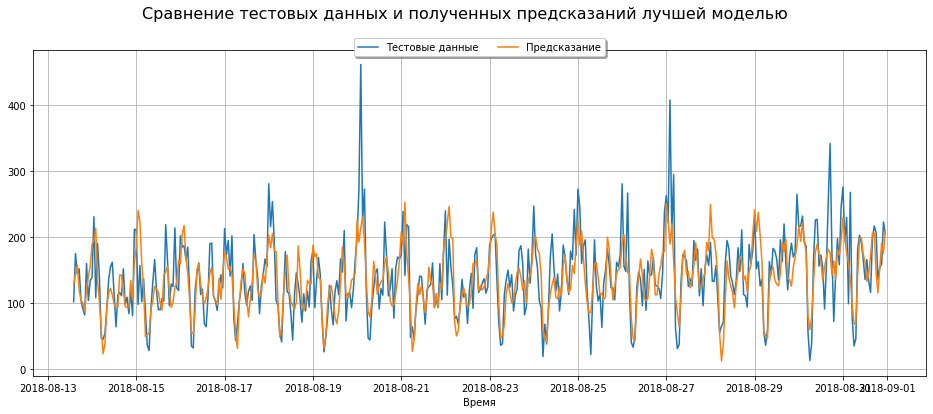

In [37]:
# данные для графика
data_plot = data_prediction['2018-08-13':'2018-08-31']
# построение графика
plt.figure(figsize=(16, 6))
plt.suptitle('Сравнение тестовых данных и полученных предсказаний лучшей моделью', fontsize=16)
plt.plot(data_plot.index, data_plot['num_orders'], label='Тестовые данные')
plt.plot(data_plot.index, data_plot['predictions'], label='Предсказание')
plt.xlabel("Время")
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True, shadow=True);

## Выводы:

1. Данные загружены и изучены.
2. Произведено семплирование данных по 1 часу.
3. Ряд был разделены на тренд и сезонность:
   - На графике треда мы видим рост;
   - Сезонная часть является статической, если рассмтатривать  интервал 1 сутки;
   - Наблюдается постоянное среднее значение у случайной части.
   - Есть всплески в днях являющимся выходными.
4. Для исследования была выбрана модель Линейной регресии.
5. Подобраны параметры скользящего окна и максимального смещения позволившего получить RMSE = 40 на тестовой выборке.
6. Построен сравнительный график полученных предсказаний и тестовых данных. На графике видно, что модель хорошо описывает ежедневные данные. Редкие пики (выходные), которые есть в тестовых данных, модель не предсказывает.